In [1]:
# python
import sys
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from storage_utils.patients_data_new import patients
import os
from biosppy.signals import ecg
import matplotlylib as pltly

/home/franciscosargo/.virtualenvs/pre-epi-seizures/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# matlab
import matlab
import matlab.engine

# Start the matlab engine
eng1 = matlab.engine.start_matlab()

In [3]:
def uni_numpy2matlab(numpy_array):
    return matlab.double(numpy_array.to_list())

def uni_matlab2numpy(matlab_array):
    return np.asarray(matlab_array)

In [4]:
def detect_rpeaks(feature_signal, detector, sampling_rate):
    # detect rpeaks
    rpeaks = detector(signal=feature_signal,
                      sampling_rate=sampling_rate)['rpeaks']
    return rpeaks

## 1) The first step is to Load the data ...

### Loading .hdf5 files containing Raw and filtered Ecg Signals

In [5]:
# Open data file
# load the file

disk='/mnt/Seagate/'
files_dir = 'h5_files_backup/processing_datasets/'
file_name = 'seizure_datasets_new.h5'
file_path = disk + files_dir + file_name
print file_path
f = h5py.File(file_path, 'r')


/mnt/Seagate/h5_files_backup/processing_datasets/seizure_datasets_new.h5


In [6]:
# Get Filtered and Detrended signal

# patient parameters
patient_number=3
patient_info = patients[str(patient_number)]
patient_info

# feature for analysis
feature_name=('signals/3000_1200'
              '/raw')

seizures = f[feature_name].keys()

# get seizures from patient
seizures_from_patient = [seizure
                         for seizure in seizures
                         if seizure.split('_')[0] == str(patient_number)]


# Example for one seizure  --careful for channel problem
seizure_number=0
seizure_name = seizures_from_patient[seizure_number]

types_of_seizure = patient_info['types_of_seizure']
type_of_seizure = types_of_seizure[seizure_number]

# get the hdf5 dataset
seizure_hdfdataset = f[feature_name + '/' + seizure_name]

# load the array to memory
seizure_array = seizure_hdfdataset[:]


# Load the array into unidimensional signal, since it is unidimensional ECG
raw_ecg = seizure_array

# feature for analysis
feature_name=('signals/3000_1200'
              '/raw'
              '/MedianFIR')

# get the hdf5 dataset
seizure_hdfdataset = f[feature_name + '/' + seizure_name]

# load the array to memory
seizure_array = seizure_hdfdataset[:]

# Load the array into unidimensional signal
# since it is unidimensional ECG, i.e index=0
medianFIR_ecg = seizure_array[0]


In [7]:
type_of_seizure

'G-A-M'

## 2) Fiducial points detection, comparing R-peak detectors, exploring outlier removal

### 2.1) Comparison between the classical method by P.S.Hamilton and a modified version 

In [8]:
# Detect rpeaks Classic Hamilton method
print medianFIR_ecg

rpeaks_hamilton = ecg.hamilton_segmenter(signal=medianFIR_ecg.T,
                                sampling_rate=1000)['rpeaks']

rpeaks_hamilton


[ 5.75376776e-16 -1.04322556e+01 -2.07034026e+01 ... -4.71827042e+02
 -4.79080581e+02 -4.85449193e+02]


array([   1009,    2090,    3183, ..., 4198659, 4199075, 4199603])

In [9]:
import ecg.models_francis as francis
print medianFIR_ecg
# Detect rpeaks modified hamilton method, by aluno Francisco IT
rpeaks_modhamilton = francis.hamilton(False,
                                            medianFIR_ecg,
                                            Filter=False)['R']
rpeaks_modhamilton = np.array(rpeaks_modhamilton)
rpeaks_modhamilton

[ 5.75376776e-16 -1.04322556e+01 -2.07034026e+01 ... -4.71827042e+02
 -4.79080581e+02 -4.85449193e+02]


array([   1009,    2090,    3183, ..., 4198517, 4199136, 4199931])

### 2.2) Compute time-domain (Load from disk) of ECG data, and compute RRi signal

In [10]:
# Get the time parameters of the signal
Fs=1000
sec_before_onset = 50 * 60
sec_after_onset = 20 * 60
relative_time_seconds = np.linspace(-sec_before_onset, sec_after_onset, 
                           (sec_before_onset + sec_after_onset) * Fs)   # relative time-frame to EEG onset
time_sec = np.linspace(0, (sec_before_onset + sec_after_onset),
                           (sec_before_onset + sec_after_onset) * Fs)   # time-frame relative
                                                                        # to the beggining of acquisition
# Get seizure id
seizure_id = seizure_name.split('_')
lead_name = seizure_id[2]
seizure_nr = seizure_id[-1]
patient_nr = seizure_id[0]

In [11]:
# compute rr-tachogram --make sure all time considerations are made right
time_rpeaks_hamilton = time_sec[rpeaks_hamilton]
rri_hamilton = np.diff(time_rpeaks_hamilton)
time_sec_rri = time_rpeaks_hamilton[1:]
relative_time_sec_rri = relative_time_seconds[rpeaks_hamilton][1:]


time_rpeaks_modhamilton = time_sec[rpeaks_modhamilton]
rri_modhamilton = np.diff(time_rpeaks_modhamilton)
time_sec_rri_modhamilton = time_rpeaks_modhamilton[1:]
relative_time_sec_modrri = relative_time_seconds[rpeaks_modhamilton][1:]

ecg_rpeak_amps_hamilton = medianFIR_ecg[rpeaks_hamilton]
ecg_rpeak_amps_modhamilton = medianFIR_ecg[rpeaks_modhamilton] 

assert len(rri_hamilton) == len(time_rpeaks_hamilton) - 1
assert len(rri_modhamilton) == len(time_rpeaks_modhamilton) - 1

In [12]:
# Check removal of outliers 

# fixed time-window for analysis

# Define a window for analysis, in seconds, right here. Make a list, it is simpler
# --->
window_interpolation = [120, 130]
#-------------------------------------------------------

# Get a window of the time samples, plus element for interpolation
time_sec_bool = np.where(np.logical_and(time_sec_rri>=window_interpolation[0],
                                        time_sec_rri<=window_interpolation[-1]))

# Get RRi signal
window_time_sec_rri = time_sec_rri[time_sec_bool]
window_rri = rri_hamilton[time_sec_bool]

window_time_sec_rri_modhamilton = time_sec_rri_modhamilton[time_sec_bool]
window_rri_modhamilton = rri_modhamilton[time_sec_bool]


print '------------------'
print 'These are the results of RRI Tachogram'
print time_rpeaks_hamilton
print time_rpeaks_modhamilton

print '------------------'
print 'These are the results of RRI Tachogram'
print window_rri
print window_rri_modhamilton



------------------
These are the results of RRI Tachogram
[1.00900024e+00 2.09000050e+00 3.18300076e+00 ... 4.19866000e+03
 4.19907600e+03 4.19960400e+03]
[1.00900024e+00 2.09000050e+00 3.18300076e+00 ... 4.19851800e+03
 4.19913700e+03 4.19993200e+03]
------------------
These are the results of RRI Tachogram
[1.02200024 1.06600025 1.01800024 1.07300026 1.08100026 1.04900025
 1.03400025 0.49900012 0.49800012 0.96000023 0.92400022]
[1.02200024 1.06600025 1.01800024 1.07300026 1.08100026 1.04900025
 1.03400025 0.47600011 0.52100012 0.96000023 0.92400022]


### 2.3) Compare Detection as proposed by P.S. Hamilton [1], and modified by Francisco IT [2]

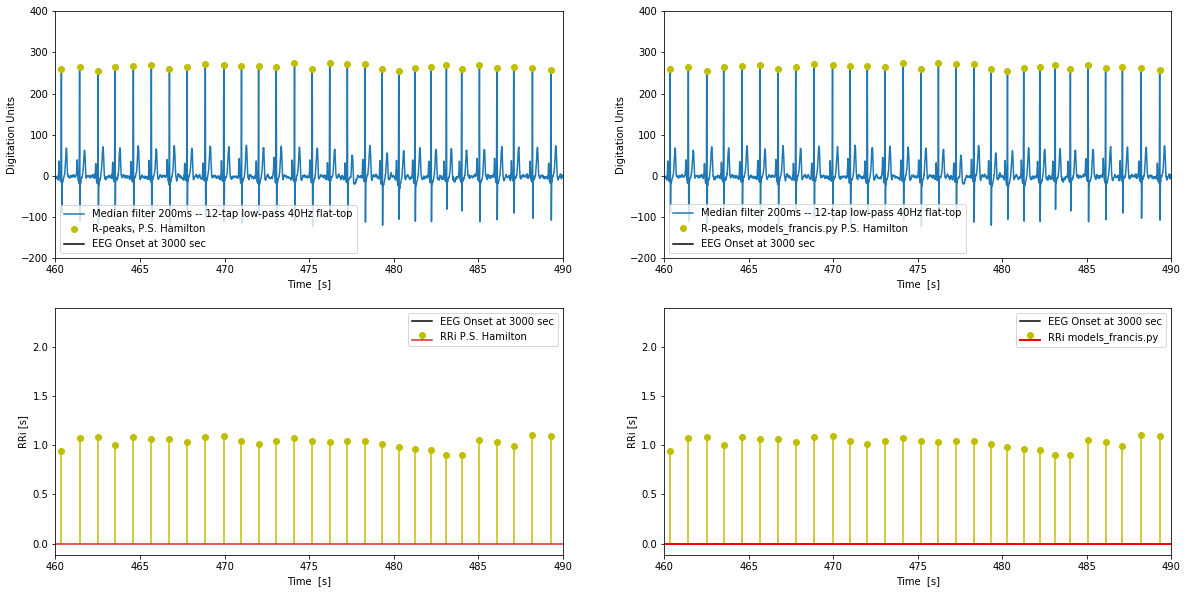

MedianFIRecg-rpeaks__hamilton-rri_stem-MedianFIRecg_rpeaks__modhamilton__t[460, 490]__y[-200, 400]


In [13]:
# Compare RRI computation between P.S. Hamilton and modified
# (Test object-based plotting)

window = [460, 490]

ecg_y_window = [-200, 400]

# Plot the signal
fig = plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(time_sec, medianFIR_ecg.T,
         label='Median filter 200ms -- 12-tap low-pass 40Hz flat-top')
plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'yo', 
         label='R-peaks, P.S. Hamilton')
plt.axvline(x=50*60, c='k', label='EEG Onset at {} sec'.format(50*60))
plt.xlabel('Time  [s]')
plt.ylabel('Digitation Units')
plt.xlim(window)
plt.ylim(ecg_y_window)
plt.legend(loc=3)

plt.subplot(2, 2, 2)
plt.plot(time_sec, medianFIR_ecg.T,
         label='Median filter 200ms -- 12-tap low-pass 40Hz flat-top')
plt.plot(time_sec[rpeaks_modhamilton], medianFIR_ecg.T[rpeaks_modhamilton], 'yo', 
         label='R-peaks, models_francis.py P.S. Hamilton')
plt.axvline(x=50*60, c='k', label='EEG Onset at {} sec'.format(50*60))
plt.xlabel('Time  [s]')
plt.ylabel('Digitation Units')
plt.xlim(window)
plt.ylim(ecg_y_window)
plt.legend(loc=3)

plt.subplot(2, 2, 3)
plt.stem(time_sec_rri, rri_hamilton, 'y', markerfmt='yo', label='RRi P.S. Hamilton')
plt.axvline(x=50*60, c='k', label='EEG Onset at {} sec'.format(50*60))
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)
plt.legend()

plt.subplot(2, 2, 4)
#plt.stem(time_sec_rri_modhamilton, rri_modhamilton, 'y', markerfmt='yo')
markerline, stemlines, baseline = plt.stem(time_sec_rri_modhamilton,
                                           rri_modhamilton,
                                           '-',
                                           label='RRi models_francis.py')
plt.setp(markerline, 'color', 'y')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
#plt.setp(stemlines, 'linestyle', 'dotted')
plt.setp(baseline, 'color','r', 'linewidth', 2)
plt.axvline(x=50*60, c='k', label='EEG Onset at {} sec'.format(50*60))
plt.legend()
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)

plt.show() 

print 'MedianFIRecg-rpeaks__hamilton-rri_stem-MedianFIRecg_rpeaks__modhamilton__t{}__y{}'.format(window, ecg_y_window)

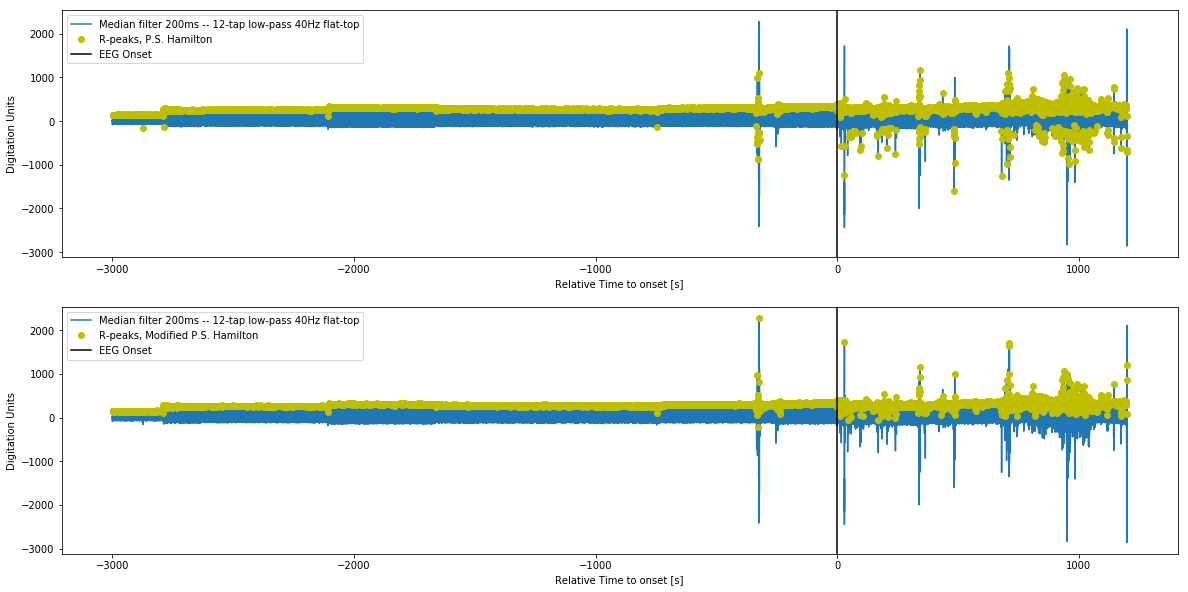

In [14]:
# Compare R-peaks detection
plt.figure(figsize=(20, 10))

plt.subplot(211)
plt.plot(relative_time_seconds, medianFIR_ecg.T)
plt.plot(relative_time_seconds[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'yo')

plt.axvline(x=0, c='k')
plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' ,
            'R-peaks, P.S. Hamilton',
            'EEG Onset'])
plt.xlabel('Relative Time to onset [s]')
plt.ylabel('Digitation Units')

plt.subplot(212)
plt.plot(relative_time_seconds, medianFIR_ecg.T)
plt.plot(relative_time_seconds[rpeaks_modhamilton],
         medianFIR_ecg.T[rpeaks_modhamilton], 'yo')

plt.axvline(x=0, c='k')
plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' ,
            'R-peaks, Modified P.S. Hamilton',
            'EEG Onset'])
plt.xlabel('Relative Time to onset [s]')
plt.ylabel('Digitation Units')
plt.show() 

### 2.4) Study Automatic artifact removal as proposed by Miguel Martinho IT [3]




In [35]:
bpm_range = [40, 170]  # physiological heart range, in bpm
sampling_rate = 1e3  # in Hz
weights_t = [0.6, 1.3]  # heart rate context weights
max_diff = 4  # forgetting time interval
memory_size = 5  # number of last accepted peaks considered
weights_a = [200, 400]  # fiducial point amplitude context weights

# Prepare inputs for r-peaks outlier removal
peaks_amp_arr = ecg_rpeak_amps_modhamilton
peaks_diff_arr = rri_modhamilton

peaks_diff_arr
peaks_amp_arr

array([ 142.42660144,  144.20228239,  142.69797256, ...,   90.61675234,
       1201.22889661,  865.16605945])

In [36]:
# Explore Miguel Martinho's r-peaks outlier removal
import hr_amp_outlier_removal as mm_outlier


outlier_dec = mm_outlier.AdaContextHRAmpWaveOutlier(bpm_range,
                                                    sampling_rate,
                                                    weights_t,
                                                    max_diff,
                                                    memory_size,
                                                    weights_a)


valid_peaks_hamilton = outlier_dec.run(peaks_amp_arr=ecg_rpeak_amps_hamilton,
                                       peaks_diff_arr=rri_hamilton)

valid_peaks_modhamilton = outlier_dec.run(peaks_amp_arr=ecg_rpeak_amps_modhamilton,
                                          peaks_diff_arr=rri_modhamilton)

#print valid_peaks




--Init
[1.08100026 1.09300026 1.06000025 ... 0.017      0.4160001  0.52800013]
[ 142.42660144  144.20228239  142.69797256 ... -701.74902967 -337.37081696
  111.93083633]
__________

--Init
[1.08100026 1.09300026 1.06000025 ... 0.88900021 0.61900015 0.79500019]
[ 142.42660144  144.20228239  142.69797256 ...   90.61675234 1201.22889661
  865.16605945]
__________



In [37]:
time_sec_cleaned_rri_hamilton = time_sec_rri[valid_peaks_hamilton]
cleaned_rri_hamilton = rri_hamilton[valid_peaks_hamilton]

time_sec_cleaned_rri_modhamilton = time_sec_rri_modhamilton[valid_peaks_modhamilton]
cleaned_rri_modhamilton = rri_modhamilton[valid_peaks_modhamilton]

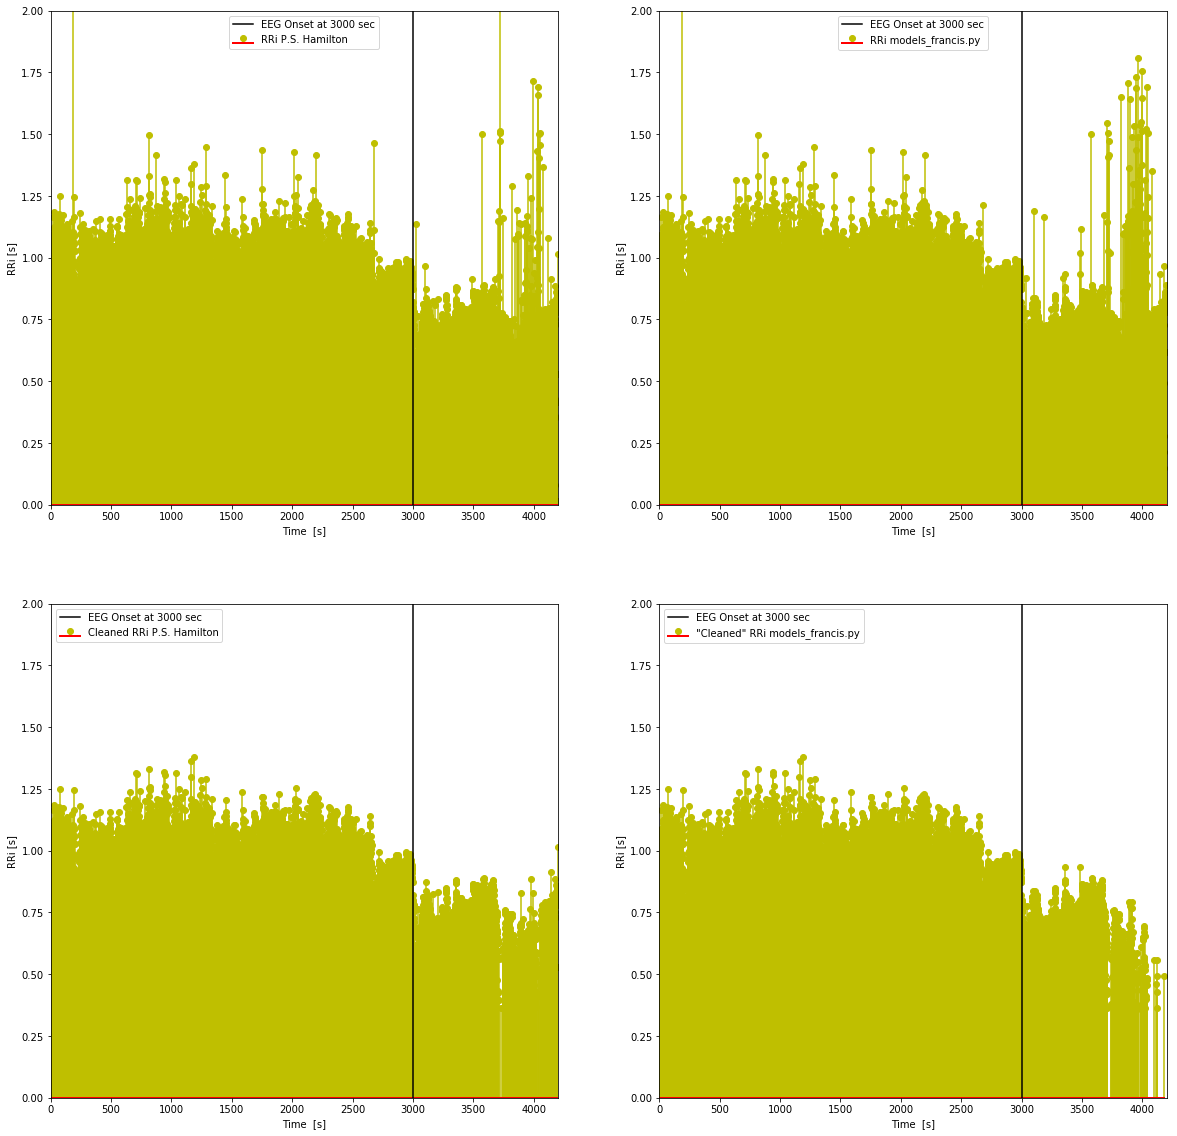

rri:stem__hamilton-rri-stem__modhamilton__dirty-cleaned__t[0, 4200]__y[-200, 400]


In [53]:
# Compare RRI computation between P.S. Hamilton and modified
# (Test object-based plotting)

window = [0, 4200]

ecg_y_window = [-200, 400]

rri_y_window = [0, 2]

# Plot the signal
fig = plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
markerline, stemlines, baseline = plt.stem(time_sec_rri,
                                           rri_hamilton,
                                           '-',
                                           label='RRi P.S. Hamilton')
plt.setp(markerline, 'color', 'y')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(baseline, 'color','r', 'linewidth', 2)
plt.axvline(x=50*60, c='k', label='EEG Onset at {} sec'.format(50*60))
plt.legend()
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)
plt.ylim(rri_y_window)


plt.subplot(2, 2, 2)
markerline, stemlines, baseline = plt.stem(time_sec_rri_modhamilton,
                                           rri_modhamilton,
                                           '-',
                                           label='RRi models_francis.py')
plt.setp(markerline, 'color', 'y')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(baseline, 'color','r', 'linewidth', 2)
plt.axvline(x=50*60, c='k', label='EEG Onset at {} sec'.format(50*60))
plt.legend()
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)
plt.ylim(rri_y_window)


plt.subplot(2, 2, 3)
markerline, stemlines, baseline = plt.stem(time_sec_cleaned_rri_hamilton,
                                           cleaned_rri_hamilton,
                                           '-',
                                           label='Cleaned RRi P.S. Hamilton')
plt.setp(markerline, 'color', 'y')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(baseline, 'color','r', 'linewidth', 2)
plt.axvline(x=50*60, c='k', label='EEG Onset at {} sec'.format(50*60))
plt.legend()
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)
plt.ylim(rri_y_window)

plt.subplot(2, 2, 4)
markerline, stemlines, baseline = plt.stem(time_sec_cleaned_rri_modhamilton,
                                           cleaned_rri_modhamilton, '-',
                                           label='"Cleaned" RRi models_francis.py')
plt.setp(markerline, 'color', 'y')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.axvline(x=50*60, c='k', label='EEG Onset at {} sec'.format(50*60))
plt.legend()
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)
plt.ylim(rri_y_window)

plt.show() 

print 'rri:stem__hamilton-rri-stem__modhamilton__dirty-cleaned__t{}__y{}'.format(window, ecg_y_window)

In [19]:
cleaned_rri_modhamilton

array([1.08100026, 1.09300026, 1.06000025, ..., 1.35100032, 0.93400022,
       0.96800023])

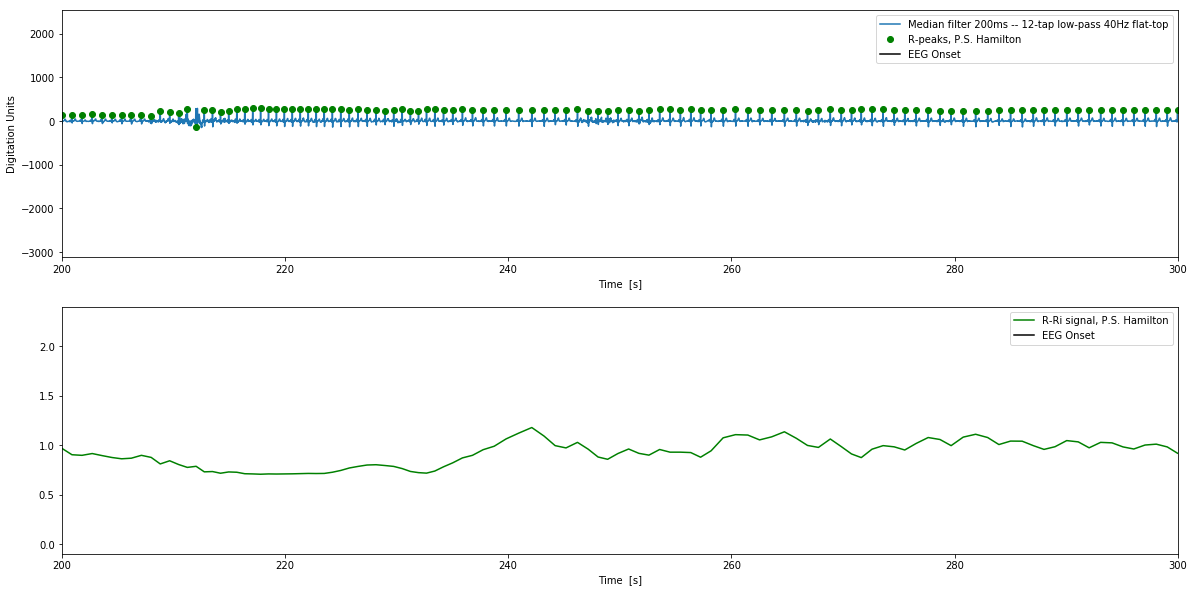

In [20]:
# Basic view RRi signal, lineplot

window = [200, 300]

# Plot the signal
plt.figure(figsize=(20, 10))

plt.subplot(211)
plt.plot(time_sec, medianFIR_ecg.T)
plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'go')
plt.axvline(x=50*60, c='k')
plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks, P.S. Hamilton', 'EEG Onset'])
plt.xlabel('Time  [s]')
plt.ylabel('Digitation Units')
plt.xlim(window)

plt.subplot(212)
plt.plot(time_sec_rri, rri_hamilton, 'g')
plt.axvline(x=50*60, c='k')
plt.legend(['R-Ri signal, P.S. Hamilton', 'EEG Onset'])
plt.xlabel('Time  [s]')

plt.xlim(window)

plt.show() 

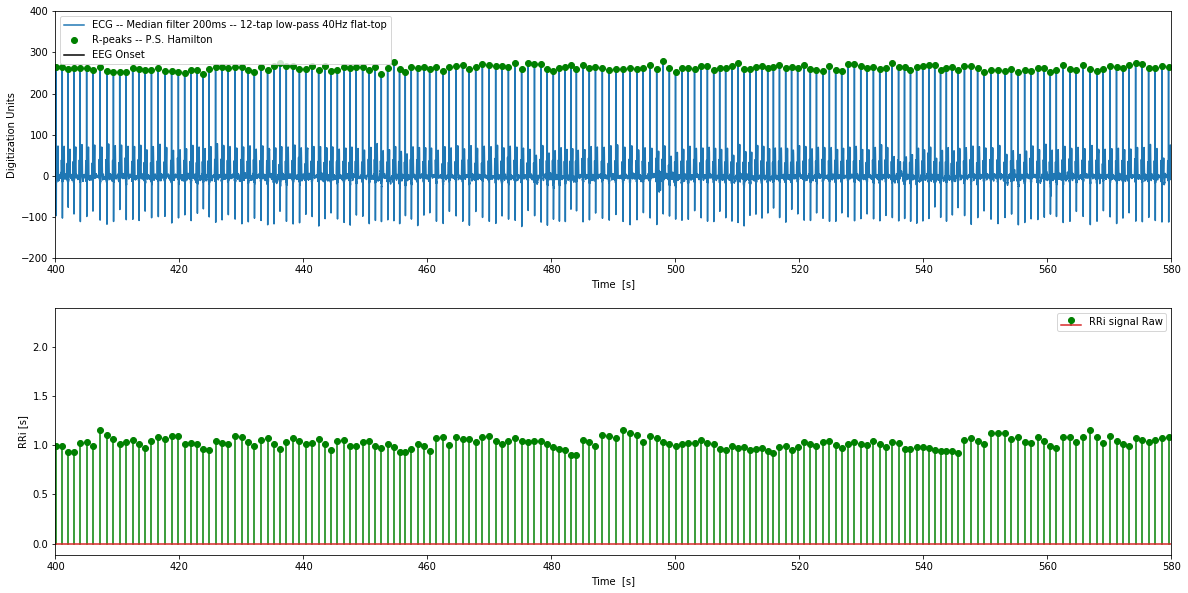

In [21]:
# Basic view RRi signal stemplot

window = [400, 580]

ecg_y_window = [-200, 400]

# Plot the signal
plt.figure(figsize=(20, 10))

plt.subplot(211)
plt.plot(time_sec, medianFIR_ecg.T)
plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'go')
plt.axvline(x=50*60, c='k')
plt.legend(['ECG -- Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks -- P.S. Hamilton', 'EEG Onset'])
plt.xlabel('Time  [s]')
plt.ylabel('Digitization Units')
plt.xlim(window)
plt.ylim(ecg_y_window)

plt.subplot(212)
plt.stem(time_sec_rri, rri_hamilton, 'g', markerfmt='go')
plt.legend(['RRi signal Raw'])
plt.axvline(x=50*60, c='k')
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)

plt.show()

In [22]:
# fixed time-window for analysis

# Define a window for analysis, in seconds, right here. Make a list, it is simpler
# --->
window_interpolation = [400, 520]
#-------------------------------------------------------

# Get a window of the time samples, plus element for interpolation
time_sec_bool = np.where(np.logical_and(time_sec_rri>=window_interpolation[0],
                                        time_sec_rri<=window_interpolation[-1]))

# Get RRi signal
window_time_sec_rri = time_sec_rri[time_sec_bool]
window_rri = rri_modhamilton[time_sec_bool]



In [23]:
from scipy.signal import resample
from scipy.interpolate import interp1d
from scipy.signal import upfirdn

# Simple increase in the number of samples
# interpolation factor
L=10
n_samples=len(window_rri)

# Compute new Sampling Frequency 
approx_fs = n_samples/(window_time_sec_rri[-1] - window_time_sec_rri[0])
approx_new_fs = approx_fs*L

# Fourrier methods
# resample - fourier method (FFT) --no assumptions on the Fs
resample_rri, resample_rri_time_sec = resample(x=window_rri,
                                               num=L*n_samples,
                                               t=window_time_sec_rri,
                                               axis=0,
                                               window=None)

# Get zero-filled array 
window_rri_zero_fill = upfirdn([1], window_rri, L)

# Approximation to 1 Hz
approx_window_time_sec_rri = np.arange(window_time_sec_rri[0],
                                       window_time_sec_rri[-1],
                                       approx_fs)

print len(approx_window_time_sec_rri)

# resample - cubic 
# Cubic spline L upsampling
f = interp1d(window_time_sec_rri,
             window_rri,
             kind='cubic')

new_domain = np.linspace(window_time_sec_rri[0],
                        window_time_sec_rri[-1],
                        n_samples * L)
resampled_rri_window_cubic = f(new_domain)


# resample - cubic
# Cubic spline 1 Hz
fs = 1
new_domain_onehz= np.arange(window_time_sec_rri[0],
                       window_time_sec_rri[-1],
                       1/fs)
resampled_rri_window_cubic_onehz = f(new_domain_onehz)

print new_domain_onehz


print 'This is uneven spaced time'
print len(window_time_sec_rri)
print window_time_sec_rri[0]
print window_time_sec_rri[-1]
print ''
print '-----------------------'

print 'This is even spaced time'
print len(window_time_sec_rri)
print window_time_sec_rri[0]
print window_time_sec_rri[-1]
print np.diff(approx_window_time_sec_rri)
print ''
print '-----------------------'

# -----------------------<<<<<<<<<<<<<
#print 'Interpolated time'
#print len(resample_rri_time_sec)
#print resample_rri_time_sec[0]
#print resample_rri_time_sec[-1]
#print np.diff(resample_rri_time_sec)
#print ''
#print '-----------------------'
# ------------------------<<<<<<<<<<<<

print 'New Domain'
print len(new_domain)
print new_domain[0]
print new_domain[-1]
print np.diff(new_domain)

print ''
print '---------------'
print 'New Domain, 1Hz'
print len(new_domain_onehz)
print new_domain_onehz[0]
print new_domain_onehz[-1]
print np.diff(new_domain_onehz)


122
[400.10609526 401.10609526 402.10609526 403.10609526 404.10609526
 405.10609526 406.10609526 407.10609526 408.10609526 409.10609526
 410.10609526 411.10609526 412.10609526 413.10609526 414.10609526
 415.10609526 416.10609526 417.10609526 418.10609526 419.10609526
 420.10609526 421.10609526 422.10609526 423.10609526 424.10609526
 425.10609526 426.10609526 427.10609526 428.10609526 429.10609526
 430.10609526 431.10609526 432.10609526 433.10609526 434.10609526
 435.10609526 436.10609526 437.10609526 438.10609526 439.10609526
 440.10609526 441.10609526 442.10609526 443.10609526 444.10609526
 445.10609526 446.10609526 447.10609526 448.10609526 449.10609526
 450.10609526 451.10609526 452.10609526 453.10609526 454.10609526
 455.10609526 456.10609526 457.10609526 458.10609526 459.10609526
 460.10609526 461.10609526 462.10609526 463.10609526 464.10609526
 465.10609526 466.10609526 467.10609526 468.10609526 469.10609526
 470.10609526 471.10609526 472.10609526 473.10609526 474.10609526
 475.1

In [49]:
# Matlab-based interpolation

# Convert numpy to matab array

matlab_window_rri = matlab.double(window_rri.tolist()) 

matlab_resampled_interp_rri_window = eng1.interp(matlab_window_rri, 10.0)

resampled_interp_rri_window = np.asarray(matlab_resampled_interp_rri_window)[0]

## Plot the results of interpolation

In [25]:
# Plot scipy.signal.resample Fixed time window, simple case

ecg_y_window = [-200, 400]

plot_flag = True
if plot_flag:
    windows_list = [[i, i + 30]
                    for i in range(window_interpolation[0],
                                    window_interpolation[-1], 30)]

    print windows_list

    windows_list.insert(0, window_interpolation)

    for window in windows_list:
        # Plot the signal
        plt.figure(figsize=(20, 10))

        plt.subplot(411)
        plt.plot(time_sec, medianFIR_ecg.T)
        plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'ro')
        plt.axvline(x=50*60, c='k')
        plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks, P.S. Hamilton', 'EEG Onset'])
        plt.xlabel('Time  [s]')
        plt.ylabel('Digitation Units')
        plt.xlim(window)
        plt.ylim([-250, 250])

        plt.subplot(412)
        plt.stem(window_time_sec_rri, window_rri, 'r', markerfmt='ro')
        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset', 'RRi signal Raw'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.subplot(413)
        plt.stem(new_domain, resample_rri, 'g', markerfmt='go')
        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset', 'RRi signal -- Fourrier Interpolation -- \n'
                    '-- scipy.signal.resample  L=10'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.subplot(414)
        plt.stem(new_domain, resample_rri, 'g', markerfmt='go')
        plt.stem(new_domain, window_rri_zero_fill, 'r', markerfmt='ro')

        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset', 'RRi signal -- Fourrier Interpolation -- \n'
                    '-- scipy.signal.resample  L=10', 'Raw RRi signal'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.show()

[[400, 430], [430, 460], [460, 490], [490, 520]]


KeyboardInterrupt: 

In [ ]:
# Cubic Spline L=10
if plot_flag:
    windows_list = [[i, i + 30]
                    for i in range(window_interpolation[0],
                                    window_interpolation[-1], 30)]
    windows_list.insert(0, window_interpolation)

    for window in windows_list:
        # Plot the signal
        plt.figure(figsize=(20, 10))

        plt.subplot(411)
        plt.plot(time_sec, medianFIR_ecg.T)
        plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'ro')
        plt.axvline(x=50*60, c='k')
        plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks, P.S. Hamilton', 'EEG Onset'])
        plt.xlabel('Time  [s]')
        plt.ylabel('Digitation Units')
        plt.xlim(window)
        plt.ylim([-250, 250])

        plt.subplot(412)
        plt.stem(window_time_sec_rri, window_rri, 'r', markerfmt='ro')
        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset', 'RRi signal Raw'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.subplot(413)
        plt.stem(new_domain, resampled_rri_window_cubic, 'y', markerfmt='yo')
        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset', 'RRi signal -- Cubic Spline L=10'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.subplot(414)
        plt.stem(new_domain, resampled_rri_window_cubic, 'y', markerfmt='yo')
        plt.stem(time_sec_rri, rri, 'r', markerfmt='ro')

        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset', 'RRi interpolated signal -- Cubic Spline L=10', 'Raw RRi signal'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.show()

In [ ]:
# matlab.interp, r=10, n=4, alpha=1

if plot_flag:

    windows_list = [[i, i + 30]
                    for i in range(window_interpolation[0],
                                    window_interpolation[-1], 30)]
    windows_list.insert(0, window_interpolation)

    for window in windows_list:
        # Plot the signal
        plt.figure(figsize=(20, 10))

        plt.subplot(411)
        plt.plot(time_sec, medianFIR_ecg.T)
        plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'ro')
        plt.axvline(x=50*60, c='k')
        plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks, P.S. Hamilton', 'EEG Onset'])
        plt.xlabel('Time  [s]')
        plt.ylabel('Digitation Units')
        plt.xlim(window)
        plt.ylim([-250, 250])

        plt.subplot(412)
        plt.stem(window_time_sec_rri, window_rri, 'r', markerfmt='ro')
        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset', 'RRi signal Raw'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.subplot(413)
        plt.stem(new_domain, resampled_interp_rri_window, 'b', markerfmt='bo')
        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset','RRi signal -- "Ideal" FIR Interpolation -- matlab.interp r=10 n=4 alpha1=1'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.subplot(414)
        plt.stem(new_domain, resampled_interp_rri_window, 'b', markerfmt='bo')
        plt.stem(new_domain, window_rri_zero_fill, 'r', markerfmt='ro')

        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset', 'RRi signal -- "Ideal" FIR Interpolation -- matlab.interp r=10 n=4 alpha=1', 'Raw RRi signal'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.show()

    #    plt.savefig(path_to_save.format(window))

In [ ]:
# Cubic Spline fs=1hz
plot_flag = True

if plot_flag:
    windows_list = [[i, i + 30]
                    for i in range(window_interpolation[0],
                                    window_interpolation[-1], 30)]
    windows_list.insert(0, window_interpolation)

    for window in windows_list:
        # Plot the signal
        plt.figure(figsize=(20, 10))

        plt.subplot(411)
        plt.plot(time_sec, medianFIR_ecg.T)
        plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'ro')
        plt.axvline(x=50*60, c='k')
        plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks, P.S. Hamilton', 'EEG Onset'])
        plt.xlabel('Time  [s]')
        plt.ylabel('Digitation Units')
        plt.xlim(window)
        plt.ylim([-250, 250])

        plt.subplot(412)
        plt.stem(window_time_sec_rri, window_rri, 'r', markerfmt='ro')
        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset', 'RRi signal Raw'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.subplot(413)
        plt.stem(new_domain_onehz, resampled_rri_window_cubic_onehz, 'm', markerfmt='mo')
        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset', 'RRi signal -- Cubic Spline fs=1Hz'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.subplot(414)
        plt.stem(new_domain_onehz, resampled_rri_window_cubic_onehz, 'm', markerfmt='mo')
        plt.stem(time_sec_rri, rri, 'r', markerfmt='ro')

        plt.axvline(x=50*60, c='k')
        plt.legend(['EEG Onset', 'RRi interpolated signal -- Cubic Spline fs=1Hz', 'Raw RRi signal'])
        plt.xlabel('Time  [s]')
        plt.ylabel('RRi [s]')
        plt.xlim(window)
        plt.ylim(0, 2)

        plt.show()

# Compute Spectral features

## Estimation of power spectral density (PSD), using the classic Periodogram:

Building on a relatively clean window of RRi signal, one possible alternative is to estimate the PSD based on the periodogram.

In [39]:
from scipy.signal import periodogram

# For resampled signal using scipy resample:
rrwf_f, rrwf_psd_periodogram = periodogram(resample_rri,
                                           fs=approx_new_fs,
                                           scaling='spectrum')

# For resampled signal using cubic spline interpolation, scipy.interpolate.interp1d
window_rri_cubic_f, window_rri_cubic_psd_periodogram = periodogram(resampled_rri_window_cubic,
                                                                   fs=approx_new_fs,
                                                                   scaling='spectrum')

# matlab interp, 
window_rri_interp_f, window_rri_interp_psd_periodogram = periodogram(resampled_interp_rri_window,
                                                                     fs=approx_new_fs,
                                                                     scaling='spectrum')

# For resampled signal using cubic spline interpolation, scipy.interpolate.interp1d
window_rri_cubic_onehz_f, window_rri_cubic_onehz_psd_periodogram = periodogram(resampled_rri_window_cubic_onehz,
                                                                               fs=fs,
                                                                               scaling='spectrum')



In [40]:
# Compare dimensions 

print len(window_rri_cubic_onehz_psd_periodogram)
print len(resampled_rri_window_cubic_onehz)

61
120


### Estimation of PSD based on the Lomb-Scargle periodogram

In [50]:
# Spectral analysis using Lomb-Scargle periodogram

# Use scipy.signal function
from scipy.signal import lombscargle
from astropy.stats import LombScargle

# Compute Lomb Scargle spectogram
frequency, power = LombScargle(window_time_sec_rri, window_rri).autopower()

# Allocate frequencies for analysis
f = np.linspace(0.01, 1, 100)

w =  np.pi/2 * f

lombscargle = lombscargle(x=window_time_sec_rri,
                         y=window_rri,
                         freqs= w)



## Estimation of PSD based on the Welch's method

In [42]:
# Spectral analysis using Welch's Method 



## 2. Estimation of PSD based on Yule-Walker equations

In [48]:
# yule-walker from python spectrum

from spectrum import aryule, arma2psd

order = 20
ar, variance, coeff_reflection = aryule(resampled_rri_window_cubic_onehz, order)

ar



array([-1.00650432,  0.08083033, -0.07070727, -0.05640397,  0.05321632,
        0.03824322, -0.09291369,  0.04649541,  0.03628381,  0.00732245,
       -0.01656893, -0.04834578,  0.01709741,  0.05378601, -0.06636361,
        0.00444315,  0.02971858, -0.00209197, -0.00361095,  0.00519676])

In [47]:
# yule-walker from matlab
matlab_resampled_rri_window_cubic_onehz = matlab.double(resampled_rri_window_cubic_onehz.tolist()) 

pxx, f = eng1.pyulear(matlab_resampled_rri_window_cubic_onehz, 20.0, nargout=2)

psd = uni_matlab2numpy(pxx)
f = uni_matlab2numpy(f)

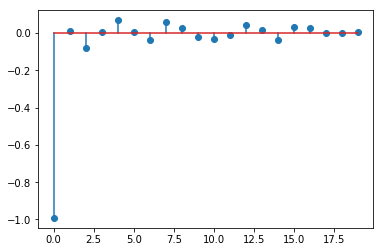

In [45]:
plt.figure()
plt.stem(coeff_reflection)
plt.show()

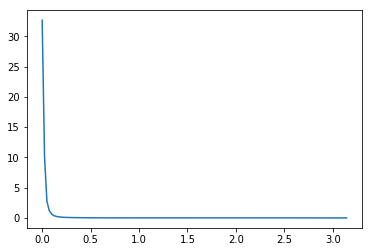

In [46]:
plt.figure()
plt.plot(f.T[0], psd.T[0])
plt.show()

In [ ]:
# plot PSD estimation based on the periodogram
plt.figure(figsize=(15, 15))

plt.subplot(411)
plt.plot(rrwf_f, rrwf_psd_periodogram, 'g')
plt.plot()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [sec**2]')
plt.legend(['scipy.signal.resample interpolation ~10hz -- Periodogram estimation'
            ' -- \n -- PSD nr of samples:{}'.format(len(rrwf_f))])
plt.xlim(0, 1)

plt.subplot(412)
plt.plot(window_rri_cubic_f, window_rri_cubic_psd_periodogram, 'y')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [sec**2]')
plt.legend(['Cubic Spline interpolation ~10hz -- Periodogram estimation'
            ' -- \n -- PSD nr of samples:{}'.format(len(window_rri_cubic_f))])
plt.xlim(0, 1)

plt.subplot(413)
plt.plot(window_rri_interp_f, window_rri_interp_psd_periodogram, 'b')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [sec**2]')
plt.legend(['matlab.interp interpolation ~10hz -- Periodogram estimation'
            ' -- \n -- PSD nr of samples:{}'.format(len(window_rri_interp_f))])
plt.xlim(0, 1)

plt.subplot(414)
plt.plot(window_rri_cubic_onehz_f, window_rri_cubic_onehz_psd_periodogram, 'm')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [sec**2]')
plt.legend(['Cubic Spline interpolation 1hz -- Periodogram estimation'
            ' -- \n -- PSD nr of samples:{}'.format(len(window_rri_cubic_onehz_f))])
plt.xlim(0, 1)

In [ ]:
# plot lombscargle periodogram 

plt.figure(figsize=(15, 15))



plt.subplot(423)
plt.plot(frequency, power, 'b', label='')
plt.xlabel('frequency [Hz]')
plt.ylabel('Unitless')
plt.legend(['Lomb-Scargle Peridogram estimation -- PSD samples: {}'.format(len(frequency))])
plt.xlim(0, 0.5)




In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.stem(coeff_reflection)
plt.xlabel('Coefficient Number')
plt.ylabel('Coefficient')



In [ ]:

f_window = [0, 0.5]


plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.plot(rrwf_f, rrwf_psd_periodogram, 'g')
plt.xlim(f_window)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

plt.subplot(222)
plt.plot(rrwc_f, rrwc_psd_periodogram, 'y')
plt.xlim(f_window)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

In [ ]:
window = [0, 70*60]

# Compare detrending with raw
plt.figure(figsize=(20, 15))

# plot the original raw ecg
plt.subplot(311)
plt.plot(time_sec, raw_ecg)
plt.axvline(x=50*60, c='k')
plt.annotate('Discontinuity', xy=(200, 50),
              xytext=(0.15, 0.80),    # fraction, fraction
              textcoords='figure fraction',
              arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel('Time[s]')
plt.ylabel('Digitation Units')
plt.legend(['Raw ECG', 'EEG Onset'])
plt.xlim(window)

# plot the detrended and denoised ecg
plt.subplot(312)
plt.plot(time_sec, medianFIR_ecg)
plt.annotate('Poorly removed discontinuity', xy=(200, 50),
              xytext=(0.15, 0.58),    # fraction, fraction
              textcoords='figure fraction',
              arrowprops=dict(facecolor='black', shrink=0.05))
plt.axvline(x=50*60, c='k')
plt.xlabel('Time [s]')
plt.ylabel('Digitation Units')
plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'EEG Onset'])
plt.xlim(window)

# plot differences (direct plot)
plt.subplot(313)
plt.plot(time_sec, raw_ecg, 'r')
plt.plot(time_sec, medianFIR_ecg, 'b')
plt.axvline(x=50*60, c='k')
plt.xlabel('Time [s]')
plt.ylabel('Digitation Units')
plt.legend(['Raw ECG', 'Median filter 200ms -- 12-tap low-pass 40Hz flat-top' ,  'EEG Onset'])
plt.xlim(window)
plt.show()

In [ ]:
# time analysis
plt.figure(figsize=(20, 20))

# plot the original ecg
plt.subplot(311)
plt.plot(time_sec, raw_ecg)

# plot the original ecg
plt.subplot(312)
plt.plot(time_sec, medianFIR_ecg)
#plt.plot(time_rpeaks, medianFIR_ecg[rpeaks], 'o')

plt.subplot(313)
plt.plot(time_sec_rri, rri, 'r')

plt.show()


In [ ]:
stop

In [ ]:

# Plot the signal
plt.figure(figsize=(20, 20))
plt.plot(relative_time_sec_rri, rri)

plt.axvline(x=0, c='k')
plt.legend(['RRi signal', 'EEG Onset'])
plt.xlabel('Relative Time to onset [s]')
plt.ylabel('RRi [seconds]')
plt.title(seizure_name + ' ' + '|' + ' ' + type_of_seizure)
plt.show() 

In [ ]:
# Get arrays for rri analysis

# DO NOT FORGET RAW

samples_window_flag = True

if samples_window_flag==True:
    
    # get structure of window for rri signal 
    n_samples = 180
    low = 0
    up = low + n_samples
    
    # Get RRi signal
    samples_window_time_sec_rri = time_sec_rri[low:up]
    samples_window_rri = rri[low:up]
    

    
assert len(samples_window_time_sec_rri) == 180
assert len(samples_window_rri) == 180


In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(611)
plt.plot(time_seconds, medianFIR_ecg.T)
plt.axvline(x=0, c='k')
plt.xlim([0, 10])
plt.xlabel('Time[s]')
plt.ylabel('Digitation Units')
plt.legend(['Detrended and denoised ECG signal (medianFIR)'])

plt.subplot(612)
plt.plot(time_seconds, medianFIR_ecg.T)
plt.plot(time_seconds[rpeaks], medianFIR_ecg.T[rpeaks], 'yo')
plt.axvline(x=0, c='k')
plt.xlim([0, 10])
plt.xlabel('Time[s]')
plt.ylabel('Digitation Units')
plt.legend(['Detrended and denoised ECG signal (medianFIR)', 'rpeaks'])

plt.subplot(613)
plt.stem(samples_window_time_sec_rri, samples_window_rri, 'r',
         markerfmt='go')
plt.xlim([0, 10])
plt.xlabel('Time[s]')
plt.ylabel('RR interval [s]')
plt.legend(['Raw RRi signal'])
plt.show()



In [ ]:
plt.subplot(614)
plt.stem(resample_rri_time_sec,
         resample_rri, 'r-')
plt.xlim([0, 10])
plt.xlabel('Time[s]')
plt.ylabel('RR interval [s]')
plt.legend(['scipy resample -- Fourrier method -- L={}'.format(L)])

plt.subplot(615)
plt.stem(resamp_poly_rri, 'g')
plt.xlabel('Samples [n]')
plt.ylabel('RR interval [s]')
plt.legend(['Interpolated using upfirdn'])

plt.subplot(616)
plt.stem(upfirdn_rri, 'g')
plt.legend(['Interpolated using upfirdn'])
plt.xlabel('Samples [n]')
plt.ylabel('RR interval [s]')
plt.show()

In [ ]:
# Plot the frequency response of the 'ls' interpolation filter 

plt.figure()
mfreqz(b)
plt.show()

plt.figure()
impz(b)
plt.show()



In [ ]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout

In [ ]:
init_notebook_mode(connected=True)

In [ ]:


iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])